Reference: [49] PyTorch [Tabular] —Multiclass Classification

https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab 

In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
plt.style.use("ggplot")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read Data
df = pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/12_face_pose_merged/ekman/openface_plus_openpose_inner_without_NaN_success0.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,0,0,1,0,0.00,0.98,1,0.217484,0.400964,-0.889904,0.050022,0.410571,-0.910455,0.148,0.423,688.7,689.9,694.0,698.6,700.9,700.0,695.6,691.1,681.6,684.7,688.8,693.5,698.2,701.8,704.6,702.1,698.2,693.6,689.1,684.9,693.1,695.0,696.8,697.3,696.3,...,0.010681,226.892,739.838,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006
1,1,1,2,0,0.04,0.98,1,0.223496,0.397311,-0.890052,0.019622,0.406862,-0.913279,0.134,0.419,687.7,689.0,693.2,697.8,700.2,699.1,694.7,690.1,680.3,683.5,687.7,692.6,697.4,701.1,703.7,701.2,697.3,692.7,688.0,683.7,692.1,694.1,695.9,696.5,695.5,...,0.009651,297.901,804.716,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570
2,2,2,3,0,0.08,0.98,1,0.220156,0.372378,-0.901591,0.014346,0.395123,-0.918516,0.128,0.399,686.9,688.3,692.5,697.1,699.3,698.2,693.7,689.1,679.7,682.8,686.9,691.8,696.6,700.3,703.0,700.3,696.4,691.7,687.2,683.0,691.3,693.2,695.1,695.7,694.7,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
3,3,3,4,0,0.12,0.98,1,0.232741,0.351699,-0.906719,0.029666,0.370821,-0.928231,0.142,0.375,684.7,686.3,690.5,695.0,697.1,695.8,691.3,686.8,677.4,680.6,684.8,689.6,694.4,698.0,700.6,697.9,694.0,689.5,684.9,680.7,689.0,690.9,692.8,693.4,692.5,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
4,4,4,5,0,0.16,0.98,1,0.220415,0.332130,-0.917119,0.030642,0.365490,-0.930311,0.135,0.361,682.3,683.9,688.2,692.6,694.6,693.3,688.7,684.3,675.2,678.5,682.7,687.5,692.1,695.7,698.2,695.6,691.7,687.1,682.6,678.4,686.5,688.4,690.3,691.0,690.1,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000


In [ ]:
df["emotion"].head()

0    anger
1    anger
2    anger
3    anger
4    anger
Name: emotion, dtype: object

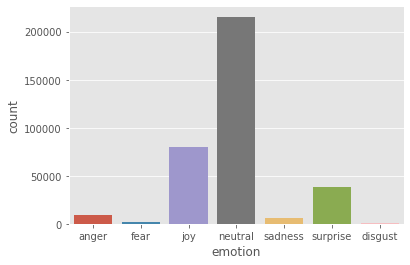

In [ ]:
# EDA and Preprocessing
# Class Distribution
sns.countplot(x = 'emotion', data=df)

In [ ]:
# Encode Output Class
class2idx = {
    'anger':0,
    'joy':1,
    'neutral':2,
    'surprise':3,
    'disgust':4,
    'sadness':5,
    'fear':6
}

idx2class = {v: k for k, v in class2idx.items()}

df['emotion'].replace(class2idx, inplace=True)

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,0,0,1,0,0.00,0.98,1,0.217484,0.400964,-0.889904,0.050022,0.410571,-0.910455,0.148,0.423,688.7,689.9,694.0,698.6,700.9,700.0,695.6,691.1,681.6,684.7,688.8,693.5,698.2,701.8,704.6,702.1,698.2,693.6,689.1,684.9,693.1,695.0,696.8,697.3,696.3,...,0.010681,226.892,739.838,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006
1,1,1,2,0,0.04,0.98,1,0.223496,0.397311,-0.890052,0.019622,0.406862,-0.913279,0.134,0.419,687.7,689.0,693.2,697.8,700.2,699.1,694.7,690.1,680.3,683.5,687.7,692.6,697.4,701.1,703.7,701.2,697.3,692.7,688.0,683.7,692.1,694.1,695.9,696.5,695.5,...,0.009651,297.901,804.716,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570
2,2,2,3,0,0.08,0.98,1,0.220156,0.372378,-0.901591,0.014346,0.395123,-0.918516,0.128,0.399,686.9,688.3,692.5,697.1,699.3,698.2,693.7,689.1,679.7,682.8,686.9,691.8,696.6,700.3,703.0,700.3,696.4,691.7,687.2,683.0,691.3,693.2,695.1,695.7,694.7,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
3,3,3,4,0,0.12,0.98,1,0.232741,0.351699,-0.906719,0.029666,0.370821,-0.928231,0.142,0.375,684.7,686.3,690.5,695.0,697.1,695.8,691.3,686.8,677.4,680.6,684.8,689.6,694.4,698.0,700.6,697.9,694.0,689.5,684.9,680.7,689.0,690.9,692.8,693.4,692.5,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
4,4,4,5,0,0.16,0.98,1,0.220415,0.332130,-0.917119,0.030642,0.365490,-0.930311,0.135,0.361,682.3,683.9,688.2,692.6,694.6,693.3,688.7,684.3,675.2,678.5,682.7,687.5,692.1,695.7,698.2,695.6,691.7,687.1,682.6,678.4,686.5,688.4,690.3,691.0,690.1,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000


In [ ]:
X = df.drop(["Unnamed: 0","Unnamed: 0.1","frame","emotion","filename","videoname"],axis=1)
y = df["emotion"]
print (X.head())
print (y.head())

   face_id  timestamp  confidence  ...  hr_point20_x  hr_point20_y  hr_point20_c
0        0       0.00        0.98  ...       236.678       745.710      0.011006
1        0       0.04        0.98  ...       307.979       783.552      0.007570
2        0       0.08        0.98  ...         0.000         0.000      0.000000
3        0       0.12        0.98  ...         0.000         0.000      0.000000
4        0       0.16        0.98  ...         0.000         0.000      0.000000

[5 rows x 1124 columns]
0    0
1    0
2    0
3    0
4    0
Name: emotion, dtype: int64


In [ ]:
# Train — Validation — Test
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
# Normalize Input
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "anger": 0,
        "joy": 0,
        "neutral": 0,
        "surprise": 0,
        "disgust":0,
        "sadness": 0,
        "fear": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['anger'] += 1
        elif i == 1: 
            count_dict['joy'] += 1
        elif i == 2: 
            count_dict['neutral'] += 1
        elif i == 3: 
            count_dict['surprise'] += 1
        elif i == 4: 
            count_dict['disgust'] += 1  
        elif i == 5: 
            count_dict['sadness'] += 1
        elif i == 6:
            count_dict['fear'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

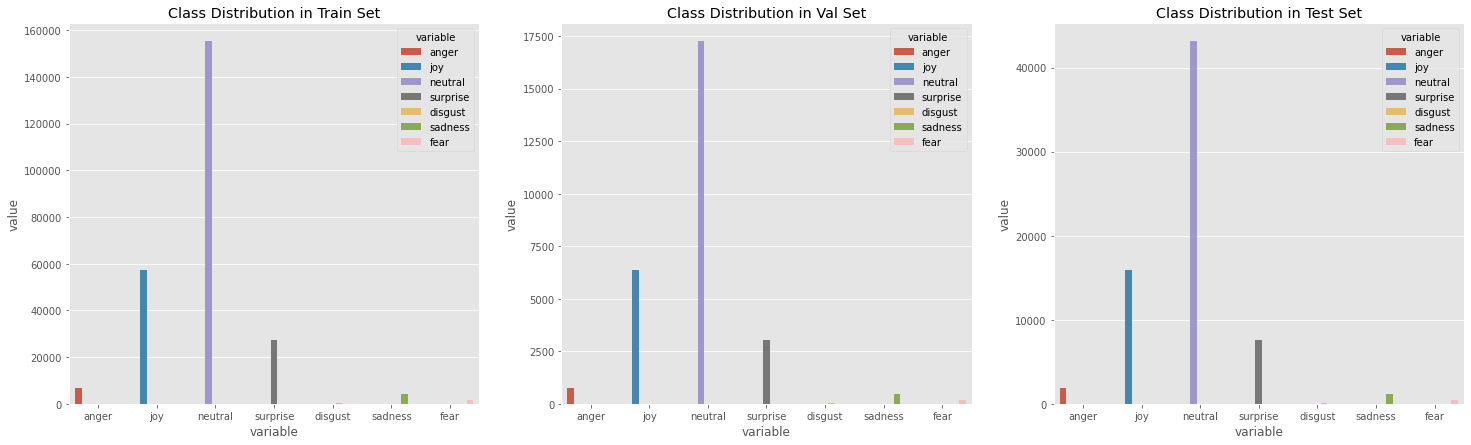

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

Text(0.5, 1.0, 'Class Distribution in Test Set')

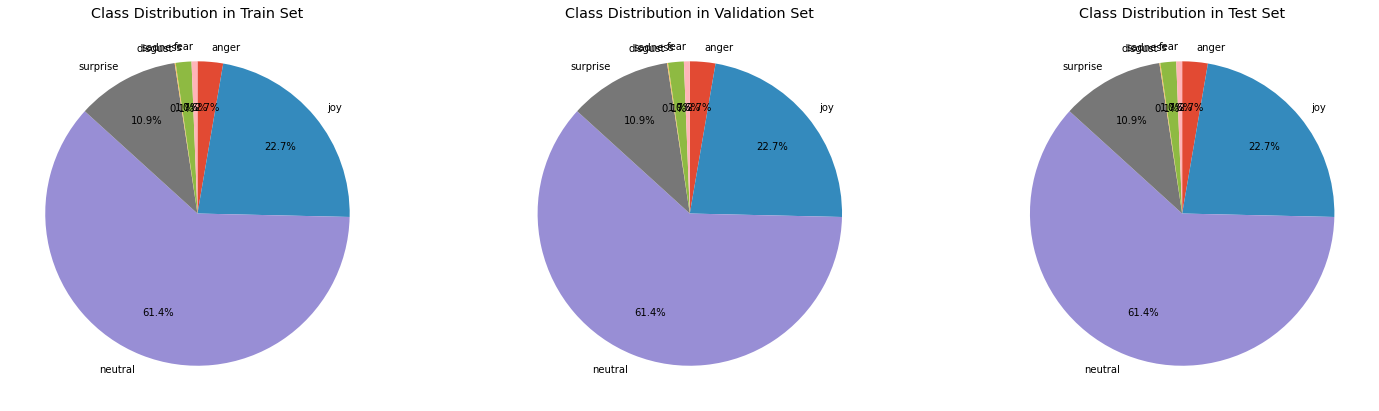

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
#sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
axes[0].pie((pd.DataFrame.from_dict([get_class_distribution(y_train)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_train)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[0].set_title("Class Distribution in Train Set")

# Validation
axes[1].pie((pd.DataFrame.from_dict([get_class_distribution(y_val)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_val)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[1].set_title("Class Distribution in Validation Set")
# Test
axes[2].pie((pd.DataFrame.from_dict([get_class_distribution(y_test)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_test)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[2].set_title("Class Distribution in Test Set")

In [ ]:
# Neural Network
# Custom Dataset
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
# Model Parameters
EPOCHS = 600 #original 300
BATCH_SIZE = 32 #original 16
LEARNING_RATE = 0.01

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 7

In [ ]:
# Dataloader
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True
    #sampler = weighted_sampler
)

val_loader = DataLoader(dataset = val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=1, shuffle=False)

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.fc1 = nn.Linear(num_feature, 400)  # All bonding layers
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, num_class)

        self.batchnorm1 = nn.BatchNorm1d(200)

    def forward(self, x):# number of inputs
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.batchnorm1(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.cuda()  # GPU
print(model)

MulticlassClassification(
  (fc1): Linear(in_features=1124, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=7, bias=True)
  (batchnorm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
# Cross-entropy error function
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Loss log
record_loss_train = []
record_loss_test = []

# Learning
for e in tqdm(range(1, EPOCHS+1)):  # Epoch Learning

    model.train()  # Training mode
    loss_train = 0.0
    for j, (x, t) in enumerate(train_loader):  # Extract mini-batch (x, t)
        x, t = x.cuda(), t.cuda()  # GPU
        optimizer.zero_grad()

        y = model(x)
        loss = loss_fnc(y, t)

        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        #pred = torch.argmax(y, dim=1)
        #acc_train += torch.mean(pred.eq(t).float())
        
    loss_train /= j+1
    record_loss_train.append(loss_train/len(train_loader))

    model.eval()  # validation
    loss_val = 0.0

    for j, (x, t) in enumerate(val_loader):  # Extract mini-batch (x, t)
        x, t = x.cuda(), t.cuda()
        y = model(x)
        loss = loss_fnc(y, t)
        loss_val += loss.item()
        #pred = torch.argmax(y, dim=1)
        #acc_val += torch.mean(pred.eq(t).float())
    

    loss_val /= j+1
    record_loss_test.append(loss_val/len(val_loader))

    if e%10 == 0:
        print("Epoch:", e, "Loss_Train:", loss_train, "Loss_Test:", loss_val)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 10 Loss_Train: 0.8494940753172875 Loss_Test: 0.8697820277648544
Epoch: 20 Loss_Train: 0.7206954838459596 Loss_Test: 0.8003558502051179
Epoch: 30 Loss_Train: 0.6329510794828525 Loss_Test: 0.921178542749133
Epoch: 40 Loss_Train: 0.6105000919513206 Loss_Test: 1.1759948410779437
Epoch: 50 Loss_Train: 0.5135863073277672 Loss_Test: 0.5555828731028989
Epoch: 60 Loss_Train: 0.4685187711991168 Loss_Test: 0.5452963144296865
Epoch: 70 Loss_Train: 0.43219428871819804 Loss_Test: 0.6829807221253386
Epoch: 80 Loss_Train: 0.400151315682632 Loss_Test: 0.5034776994770694
Epoch: 90 Loss_Train: 0.37633105877327694 Loss_Test: 0.7443231804233641
Epoch: 100 Loss_Train: 0.35402624608142197 Loss_Test: 0.6874501447779002
Epoch: 110 Loss_Train: 0.3363072036546769 Loss_Test: 0.47074284282231615
Epoch: 120 Loss_Train: 0.3189340563629118 Loss_Test: 0.45329233444195915
Epoch: 130 Loss_Train: 0.3037306902210257 Loss_Test: 0.6005092931081771
Epoch: 140 Loss_Train: 0.294409690220668 Loss_Test: 0.5118334017480797

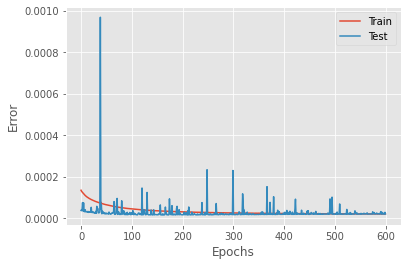

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []


columnlist = list(df.columns)[0:-1]+["emotion","label"]
print (columnlist)
correctdf = pd.DataFrame(columns=columnlist)
faildf = pd.DataFrame(columns=columnlist)
correctcount = 0
failcount = 0
for i, ((x, t)) in enumerate(test_loader):
    #print (x[0,:])
    x, t = x.cuda(), t.cuda()  # GPU
    x = x.view(-1,NUM_FEATURES)
    y = model(x)

    #output = (torch.max(torch.exp(y), 1)[1]).data.cpu().numpy()
    output = (y.argmax(1)).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    #print (output)
        
    labels = t.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
    #print (labels)

    correct += (y.argmax(1) == t).sum().item()
    
    # if y.argmax(1)==t and correctcount<1001:
    #   temp = [x1.reshape(1,414).tolist()[0]+[output[0],labels[0]]]
    #   correctdf = correctdf.append(pd.DataFrame(temp,columns=columnlist))
    #   correctcount +=1

    # elif y.argmax(1)!=t and failcount<1001:
    #   temp = [x1.reshape(1,414).tolist()[0]+[output[0],labels[0]]]
    #   #print (temp)
    #   faildf = faildf.append(pd.DataFrame(temp,columns=columnlist))
    #   failcount +=1

    total += len(x)
print("正解率:", str(correct/total*100) + "%")
print(correctdf.head())
print(faildf.head())

['Unnamed: 0', 'Unnamed: 0.1', 'frame', 'face_id', 'timestamp', 'confidence', 'success', 'gaze_0_x', 'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 'gaze_angle_x', 'gaze_angle_y', 'eye_lmk_x_0', 'eye_lmk_x_1', 'eye_lmk_x_2', 'eye_lmk_x_3', 'eye_lmk_x_4', 'eye_lmk_x_5', 'eye_lmk_x_6', 'eye_lmk_x_7', 'eye_lmk_x_8', 'eye_lmk_x_9', 'eye_lmk_x_10', 'eye_lmk_x_11', 'eye_lmk_x_12', 'eye_lmk_x_13', 'eye_lmk_x_14', 'eye_lmk_x_15', 'eye_lmk_x_16', 'eye_lmk_x_17', 'eye_lmk_x_18', 'eye_lmk_x_19', 'eye_lmk_x_20', 'eye_lmk_x_21', 'eye_lmk_x_22', 'eye_lmk_x_23', 'eye_lmk_x_24', 'eye_lmk_x_25', 'eye_lmk_x_26', 'eye_lmk_x_27', 'eye_lmk_x_28', 'eye_lmk_x_29', 'eye_lmk_x_30', 'eye_lmk_x_31', 'eye_lmk_x_32', 'eye_lmk_x_33', 'eye_lmk_x_34', 'eye_lmk_x_35', 'eye_lmk_x_36', 'eye_lmk_x_37', 'eye_lmk_x_38', 'eye_lmk_x_39', 'eye_lmk_x_40', 'eye_lmk_x_41', 'eye_lmk_x_42', 'eye_lmk_x_43', 'eye_lmk_x_44', 'eye_lmk_x_45', 'eye_lmk_x_46', 'eye_lmk_x_47', 'eye_lmk_x_48', 'eye_lmk_x_49', 'eye_lmk_x_50', '

In [ ]:
#correctdf.to_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/15_predict_emotion_from_face_pose/ekman/model03(3NN_Epoch600)/face_pose_correctdf.csv")　
#faildf.to_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/15_predict_emotion_from_face_pose/ekman/model03(3NN_Epoch600)/face_pose_faildf.csv")　

[[ 1533    77   260    17     1    12     2]
 [   60  9031  6663    84     1    62     8]
 [  190  3802 38678   271     9   124    31]
 [   30   110   465  7005     1    19     4]
 [    2     1    10     0    56     1     3]
 [   13    43   156     6     0   952     1]
 [    7    18    60     7     1     5   340]]


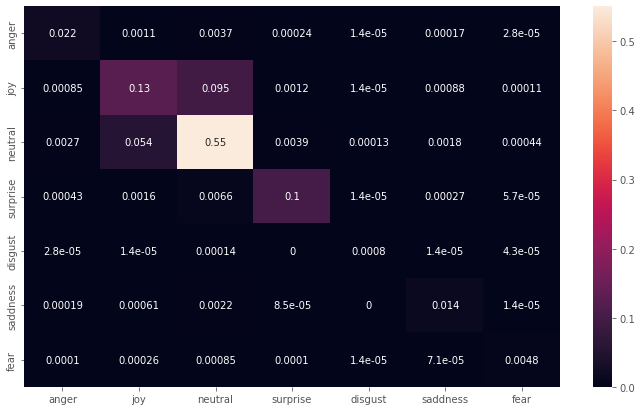

In [ ]:
import seaborn as sn
classes = ('anger', 'joy', 'neutral', 'surprise', 'disgust',
        'saddness', 'fear')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print (cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/05_workspace/01_msc_project/data/output/15_predict_emotion_from_face_pose/ekman/model03(3NN_Epoch600)/face_plus_pose_model_600epoch.pth")

In [ ]:
from sklearn.metrics import classification_report
print (classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1902
           1       0.69      0.57      0.62     15909
           2       0.84      0.90      0.87     43105
           3       0.95      0.92      0.93      7634
           4       0.81      0.77      0.79        73
           5       0.81      0.81      0.81      1171
           6       0.87      0.78      0.82       438

    accuracy                           0.82     70232
   macro avg       0.83      0.79      0.81     70232
weighted avg       0.81      0.82      0.82     70232

